In [139]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
from matplotlib.lines import Line2D

In [140]:
class EIRecLinear(nn.Module):

  r"""Recurrent E-I Linear transformation.

  This module implements a linear transformation with recurrent E-I dynamics,
  where part of the units are excitatory and the rest are inhibitory.

  Args:
      hidden_size: int, the number of units in the layer.
      e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

  __constants__ = ['bias', 'hidden_size', 'e_prop']

  def __init__(self, hidden_size, e_prop, bias=True):
    super().__init__()
    self.hidden_size = hidden_size
    self.e_prop = e_prop
    self.e_size = int(e_prop * hidden_size) # Number of excitatory units
    self.i_size = hidden_size - self.e_size # Number of inhibitory units

    # Weight matrix for the recurrent connections
    self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

    # Create a mask to define the E-I interactions
    # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal
    mask = np.tile([1]*self.e_size+[-1]*self.i_size, (hidden_size, 1))
    np.fill_diagonal(mask, 0)
    self.mask = torch.tensor(mask, dtype=torch.float32)

    # Optionally add a bias term
    if bias:
      self.bias = nn.Parameter(torch.Tensor(hidden_size))
    else:
      self.register_parameter('bias', None)
    self.reset_parameters()

  def reset_parameters(self):
    # Initialize weights and biases
    init.kaiming_uniform_(self.weight, a=math.sqrt(5))
    # Scale the weights for the excitatory neurons
    self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

    # Initialize biases
    if self.bias is not None:
      fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
      bound = 1 / math.sqrt(fan_in)
      init.uniform_(self.bias, -bound, bound)

  def effective_weight(self):
    # Apply the mask to the absolute values of the weights to get the effective weight
    # This ensures that weights from excitatory neurons are positive,
    # and weights from inhibitory neurons are negative.
    return F.relu(self.weight) * self.mask

  def forward(self, input):
    # Apply the linear transformation using the effective weights and biases
    # The weights used are non-negative due to the absolute value in effective_weight.
    return F.linear(input, self.effective_weight(), self.bias)

class EIRNN(nn.Module):
  """E-I RNN.

  Reference:
      Song, H.F., Yang, G.R. and Wang, X.J., 2016.
      Training excitatory-inhibitory recurrent neural networks
      for cognitive tasks: a simple and flexible framework.
      PLoS computational biology, 12(2).

  Args:
      input_size: Number of input neurons
      hidden_size: Number of hidden neurons
  """

  def __init__(self, input_size, hidden_size, dt=None,
               e_prop=0.8, sigma_rec=0, **kwargs):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.e_size = int(hidden_size * e_prop)
    self.i_size = hidden_size - self.e_size
    self.num_layers = 1
    self.tau = 100
    if dt is None:
      alpha = 1
    else:
      alpha = dt / self.tau
    self.alpha = alpha
    self.oneminusalpha = 1 - alpha
    self._sigma_rec = np.sqrt(2 * alpha) * sigma_rec

    # Input to hidden linear transformation
    self.input2h = nn.Linear(input_size, hidden_size)
    # Hidden to hidden transformation with E-I structure
    self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

  def init_hidden(self, input):
    batch_size = input.shape[1]
    return torch.zeros(batch_size, self.hidden_size).to(input.device)  # Single tensor for hidden state

  def recurrence(self, input, hidden):
    """Recurrence helper with a single hidden tensor."""
    total_input = self.input2h(input) + self.h2h(hidden)
    state = hidden * self.oneminusalpha + total_input * self.alpha
    state += self._sigma_rec * torch.randn_like(state)
    output = torch.relu(state)
    return output

  def forward(self, input, hidden=None):
    """Propagate input through the network."""
    if hidden is None:
      hidden = self.init_hidden(input)

    output = []
    for i in range(input.size(0)):
      hidden = self.recurrence(input[i], hidden)
      output.append(hidden)
    output = torch.stack(output, dim=0)
    return output, hidden

class Net(nn.Module):
  """Recurrent network model.

  Args:
  input_size: int, input size
  hidden_size: int, hidden size
  output_size: int, output size
  rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
  """
  def __init__(self, input_size, hidden_size, output_size, **kwargs):
    super().__init__()

    # Excitatory-inhibitory RNN
    self.input_size = input_size
    self.rnn = EIRNN(input_size, hidden_size, **kwargs)
    self.fc = nn.Linear(self.rnn.e_size, output_size)

  def forward(self, x):
    rnn_activity, _ = self.rnn(x)
    rnn_e = rnn_activity[:, :, :self.rnn.e_size]
    out = self.fc(rnn_e)
    return out, rnn_activity


In [141]:
! git clone https://github.com/neurogym/neurogym.git
%cd neurogym/
! pip install -e .

fatal: destination path 'neurogym' already exists and is not an empty directory.
/content/neurogym/neurogym/neurogym/neurogym/neurogym/neurogym/neurogym/neurogym
Obtaining file:///content/neurogym/neurogym/neurogym/neurogym/neurogym/neurogym/neurogym/neurogym
ERROR: file:///content/neurogym/neurogym/neurogym/neurogym/neurogym/neurogym/neurogym/neurogym does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [135]:
import neurogym as ngym

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Environment
task = 'SingleContextDecisionMaking-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=5, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Step 200, Loss 0.4361
Step 400, Loss 0.2447
Step 600, Loss 0.1968
Step 800, Loss 0.1576
Step 1000, Loss 0.1243
Step 1200, Loss 0.0985
Step 1400, Loss 0.0833
Step 1600, Loss 0.0718
Step 1800, Loss 0.0648
Step 2000, Loss 0.0603
Step 2200, Loss 0.0566
Step 2400, Loss 0.0546
Step 2600, Loss 0.0520
Step 2800, Loss 0.0498
Step 3000, Loss 0.0461
Step 3200, Loss 0.0440
Step 3400, Loss 0.0423
Step 3600, Loss 0.0417
Step 3800, Loss 0.0402
Step 4000, Loss 0.0397
Step 4200, Loss 0.0385
Step 4400, Loss 0.0384
Step 4600, Loss 0.0373
Step 4800, Loss 0.0373
Step 5000, Loss 0.0375


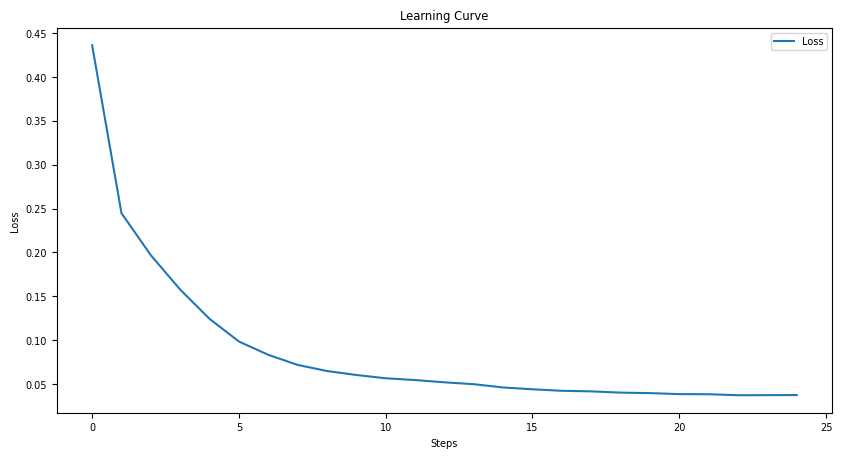

In [136]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 200
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [137]:
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
    stim_activity[env.trial['ground_truth']].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))

Average performance 0.848


Shape of the neural activity (Time points, Neurons): (50176, 50)
Shape of the projected activity (Time points, PCs): (50176, 2)


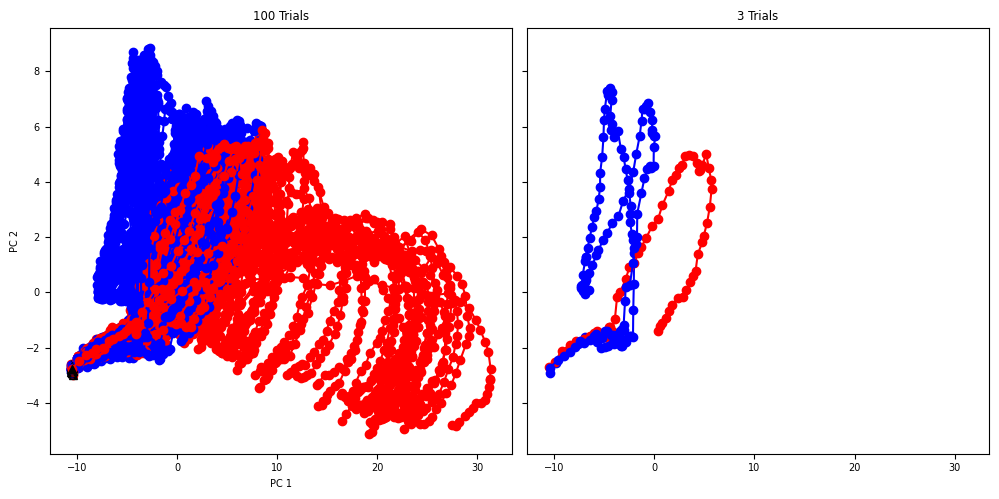

In [138]:
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyse
plot_until_time = 70



# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

# Initialize PCA and fit it on the activity data
pca = PCA(n_components=2)  # Using 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D)
print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

# Plot all trials in ax1 and fewer trials in ax2 for clarity
for i in range(100):
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

    # Color by ground truth
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'

    ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
    if i < 3:  # Fewer trials in ax2 for clear visualization
        ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

    # Indicate trial start with a different marker
    ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

# Setting labels and titles for clarity
ax1.set_title('100 Trials')
ax2.set_title('3 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

plt.tight_layout()
plt.show()


In [152]:
import neurogym as ngym

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Environment
task = 'PerceptualDecisionMakingDelayResponse-v0'
timing = {
    'fixation': ('choice', (50, 100, 200, 400)),
    'stimulus': ('choice', (100, 200, 400, 800)),
}
kwargs = {'dt': 20, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:69: UserWarning: WARN: Agent's minimum action space value is -infinity. This is probably too low.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:73: UserWarning: WARN: Agent's maximum action space value is infinity. This is probably too high
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Step 200, Loss 0.6159
Step 400, Loss 0.3956
Step 600, Loss 0.3577
Step 800, Loss 0.3422
Step 1000, Loss 0.3263
Step 1200, Loss 0.3195
Step 1400, Loss 0.3115
Step 1600, Loss 0.3039
Step 1800, Loss 0.3005
Step 2000, Loss 0.2949
Step 2200, Loss 0.2910
Step 2400, Loss 0.2953
Step 2600, Loss 0.2856
Step 2800, Loss 0.2865
Step 3000, Loss 0.2882
Step 3200, Loss 0.2806
Step 3400, Loss 0.2819
Step 3600, Loss 0.2805
Step 3800, Loss 0.2773
Step 4000, Loss 0.2835
Step 4200, Loss 0.2805
Step 4400, Loss 0.2776
Step 4600, Loss 0.2804
Step 4800, Loss 0.2800
Step 5000, Loss 0.2795


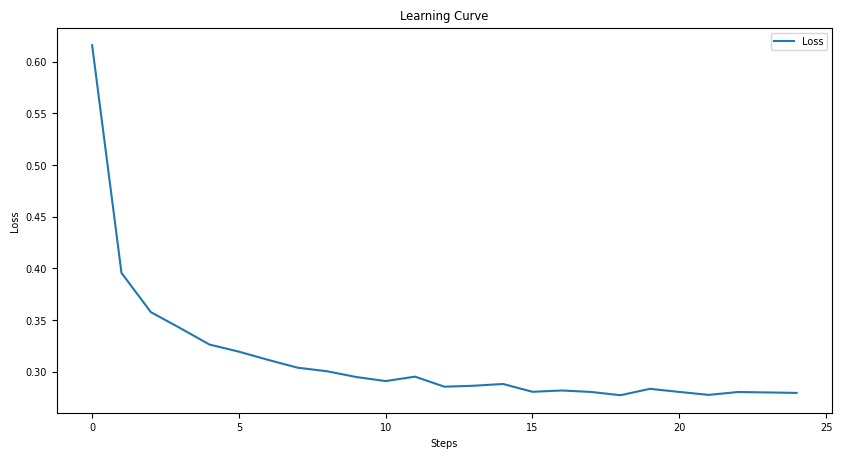

In [153]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.font_manager")

# Assuming Net is defined somewhere and dataset() function is defined
# Assuming input_size and output_size are also defined

# Instantiate the network
hidden_size = 50
net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

loss_values = []  # List to store loss values
running_loss = 0.0
print_step = 200
for i in range(5000):
    inputs, labels = dataset()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels.flatten()).type(torch.long)

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Forward pass
    output, activity = net(inputs)
    output = output.view(-1, output_size)

    # Compute loss
    loss = criterion(output, labels)

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    # Update running loss
    running_loss += loss.item()
    if i % print_step == (print_step - 1):
        average_loss = running_loss / print_step
        print('Step {}, Loss {:0.4f}'.format(i+1, average_loss))
        loss_values.append(average_loss)  # Append average loss here
        running_loss = 0.0

plt.figure(figsize=(10,5))
plt.title("Learning Curve")
plt.plot(loss_values, label='Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [154]:
env.reset(no_step=True)
env.timing.update({'fixation': ('constant', 500),
                   'stimulus': ('constant', 500)})
perf = 0
num_trial = 500
activity_dict = {}
trial_infos = {}
stim_activity = [[], []]  # response for ground-truth 0 and 1
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)

    # Compute performance
    action_pred = action_pred.detach().numpy()
    choice = np.argmax(action_pred[-1, 0, :])
    correct = choice == gt[-1]

    # Log trial info
    trial_info = env.trial
    trial_info.update({'correct': correct, 'choice': choice})
    trial_infos[i] = trial_info

    # Log stimulus period activity
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity

    # Compute stimulus selectivity for all units
    # Compute each neuron's response in trials where ground_truth=0 and 1 respectively
    rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]

    ground_truth = env.trial['ground_truth']
    while len(stim_activity) <= ground_truth:
      stim_activity.append([])
    stim_activity[ground_truth].append(rnn_activity)

print('Average performance', np.mean([val['correct'] for val in trial_infos.values()]))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Average performance 0.528


Shape of the neural activity (Time points, Neurons): (104650, 50)
Shape of the projected activity (Time points, PCs): (104650, 2)


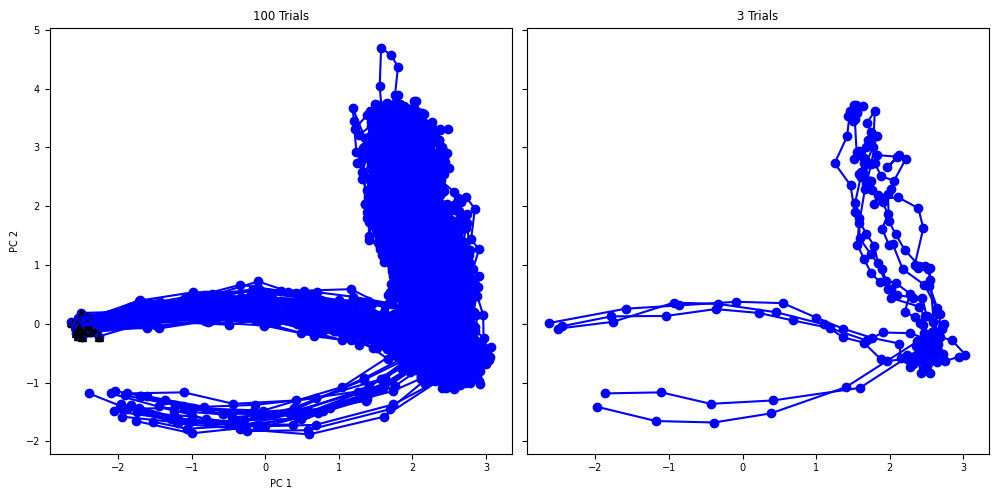

In [155]:
# Import necessary libraries
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import logging

logging.getLogger("matplotlib").setLevel(logging.CRITICAL)

num_trial = 500  # Number of trials to analyse
plot_until_time = 70



# Concatenate activity data across all trials for PCA
activity = np.concatenate([activity_dict[i] for i in range(num_trial)], axis=0)
print('Shape of the neural activity (Time points, Neurons):', activity.shape)

# Initialize PCA and fit it on the activity data
pca = PCA(n_components=2)  # Using 2 components for visualization
pca.fit(activity)
activity_pc = pca.transform(activity)  # Transform to lower dimensions (2D)
print('Shape of the projected activity (Time points, PCs):', activity_pc.shape)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))

# Plot all trials in ax1 and fewer trials in ax2 for clarity
for i in range(100):
    # Transform and plot each trial
    activity_pc = pca.transform(activity_dict[i])  # Project each trial's activity

    # Color by ground truth
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'

    ax1.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)
    if i < 3:  # Fewer trials in ax2 for clear visualization
        ax2.plot(activity_pc[:plot_until_time, 0], activity_pc[:plot_until_time, 1], 'o-', color=color)

    # Indicate trial start with a different marker
    ax1.plot(activity_pc[0, 0], activity_pc[0, 1], '^', color='black')

# Setting labels and titles for clarity
ax1.set_title('100 Trials')
ax2.set_title('3 Trials')
ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

plt.tight_layout()
plt.show()
